# FUNGI

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import packages
import os
import qiime2 as q2
import pandas as pd
import dokdo
import matplotlib.pyplot as plt
from qiime2.plugins import feature_classifier
from qiime2.plugins import feature_table
from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import filter_seqs
from qiime2.plugins.metadata.visualizers import tabulate

In [3]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [4]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

In [5]:
# summarise and visualise
feature_table.visualizers.summarize(
    table = denoisetable,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: 0294ef19-45e7-415a-963c-35875fb27c37>

## TAXONOMIC ANALYSIS 

In [6]:
# # load classifier data, bacteria classifier classifier-B-341F_802R, reference reads ref-seqs_341F_802R, reference taxonomy silva-138-99-tax
# classifier = q2.Artifact.load(f'{WORKDIR}/database/200204UNITE/developer/whole.length.classifier.qza')
# reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200204UNITE/developer/dynamic_otus.filtered.qza')
# reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200204UNITE/developer/dynamic_taxonomy.filtered.qza')

In [7]:
# model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [8]:
# choose model, run for each model_name
model_name = "hybrid"
model = models[model_name]

In [9]:
# classify the seqences using different classifiers
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [10]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [11]:
res_df

,Taxon_sklearn,Confidence_sklearn,Taxon_vsearch,Consensus_vsearch,Taxon_blast,Consensus_blast,Taxon_hybrid,Confidence_hybrid,Consensus_hybrid,Method_hybrid
Feature ID,,,,,,,,,,
df1e1733a9bc841b5bd41cfd983bfa2c,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__C...,0.9773467044766861,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__H...,0.6,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__H...,0.9,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__C...,0.9773467044766861,1.0,sklearn
1d40c9ba070d9b7343c9bb2b33d57033,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.9750434910609332,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.6666666666666666,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,1.0,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.9750434910609332,1.0,sklearn
1aa4f36fce2bf0d08b01a5021d78abb1,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__C...,0.9999644796144351,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__D...,1.0,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__D...,0.6,k__Fungi;p__Ascomycota;c__Dothideomycetes;o__C...,0.9999644796144351,1.0,sklearn
2e9581ce0aa55063fa9be4b9f62d7e1e,k__Fungi,1.0000000000000062,k__Fungi;p__Basidiomycota;c__Malasseziomycetes...,1.0,k__Fungi;p__Basidiomycota;c__Malasseziomycetes...,1.0,k__Fungi,1.0000000000000062,1.0,sklearn
049f390390919984ec0992ec8b80eff1,k__Fungi;p__Ascomycota,0.9999604862835818,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__H...,0.9090909090909091,k__Fungi;p__Ascomycota;c__Sordariomycetes;o__H...,1.0,k__Fungi;p__Ascomycota,0.9999604862835818,1.0,sklearn
...,...,...,...,...,...,...,...,...,...,...
7c54536b662713741ef87f6ac8f00292,k__Fungi;p__Ascomycota,0.8015640256740423,Unassigned,1.0,Unassigned,0.0,k__Fungi;p__Ascomycota,0.8015640256740423,1.0,sklearn
7e3b0898aa0070d23a9d66b0e3fe2894,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eu...,0.9971037397123934,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eu...,0.6428571428571429,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eu...,0.9,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eu...,0.9971037397123934,1.0,sklearn
736438c8aa44afd48031263130c845b7,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.9784925267951846,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,1.0,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,1.0,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.9784925267951846,1.0,sklearn


In [12]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save(f'./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: e3cfd96d-f78c-4b02-b4c9-0f6337667164>

In [13]:
# choose a classifier
model_name = "vsearch"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [14]:
# load classification resuls as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: 30e7bac4-4f72-404b-94f7-84e1001db0f0>

In [15]:
# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: f5d1ab64-04e9-4527-b540-998f15958bad>

### FILTER BY TAXONOMY

In [16]:
# filter denoisetable, keep only d__Fungi
denoisetable_fun = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'k__Fungi'
)
denoisetable_fun.filtered_table.save('./results/denoisetable_fun.qza')

'./results/denoisetable_fun.qza'

In [17]:
# filter rep_seqs, keep only d_Baceria
rep_seqs_fun = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'k__Fungi'
)
rep_seqs_fun.filtered_sequences.save('./results/rep_seqs_fun.qza')

/home/npajek/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/q2_taxa/_method.py:121: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return sequences[ids_to_keep]
/home/npajek/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/q2_types/feature_data/_transformer.py:254: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id_, seq in data.iteritems():


'./results/rep_seqs_fun.qza'

### TAXA PER SPECIMEN

In [18]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_fun.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [19]:
# define functions
# define extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

# define backtrace_unassigned, change Domain to Kingdom
def backtrace_unassigned_fungi(row, unassigned_like_words, invalid_words):
    columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        valid_name = [val for val in row[columns].values if val not in invalid_words][-1]
        row[columns] = [val if val not in invalid_words else f"Unclass. {valid_name}" for val in row[columns].values]
        
        valid_name = [val for val in row[columns].values if val not in unassigned_like_words][-1]
        row[columns] = [val if val not in unassigned_like_words else f"Unclass. {valid_name}_{val}" for val in row[columns].values]
    except:
        pass
    return row

# define reassemble taxon column, change Domain to Kingdom
def reassemble_taxon_fungi(row):
    columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    prefixes = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__']
    return ";".join(["".join(pair) for pair in zip(prefixes, row[columns].values)])

# remove duplicates
def remove_duplicates(row):
    columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        values = [val for val in row[columns].values if "Unclass." not in val]
        unique_values, counts = np.unique(values, return_counts=True)
        duplicate_id = np.where(counts > 1)[0][0] if any(counts > 1) else None
        
        if duplicate_id is not None:
            count = counts[duplicate_id]
            duplicate_str = unique_values[duplicate_id]
            joined_str = '|'.join(row[columns].values[::-1])
            row[columns] = re.sub(duplicate_str, f'Unclass. {duplicate_str}', joined_str, count=count-1).split('|')[::-1]
    except:
        pass
    return row

In [20]:
# run once for each sample (subject)
# choose a sample 
subject = 'P22A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Kingdom'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='k__', null_data='Unassigned'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__', null_data='Unassigned'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__', null_data='Unassigned'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__', null_data='Unassigned'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__', null_data='Unassigned'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__', null_data='Unassigned'))

invalid_words = ['unidentified', 'Unassigned']
unassigned_like_words = ['']
custom_df = custom_df.apply(backtrace_unassigned_fungi, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

custom_df['Taxon'] = custom_df.apply(reassemble_taxon_fungi, axis=1)
custom_df = custom_df.apply(remove_duplicates, axis=1)

columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus']
taxa_per_species = custom_df.groupby(columns).sum()

taxa_per_species[subject] /= taxa_per_species[subject].sum()
taxa_per_species[subject] = [f'{x*100:.3f}' for x in taxa_per_species[subject]]

# ready for latex table
print(taxa_per_species.to_latex(escape=False))

taxa_per_species

\begin{tabular}{llllll}
\toprule
              &                 &             &              &          &    P22A \\
Phylum & Class & Order & Family & Genus &         \\
\midrule
Ascomycota & Dothideomycetes & Capnodiales & Cladosporiaceae & Cladosporium &   0.009 \\
              &                 & Dothideales & Aureobasidiaceae & Aureobasidium &   2.726 \\
              &                 &             & Unclass. Dothideales & Unclass. Dothideales &   0.479 \\
              & Eurotiomycetes & Chaetothyriales & Herpotrichiellaceae & Phialophora &   0.044 \\
              &                 & Eurotiales & Aspergillaceae & Penicillium &   0.009 \\
              & Saccharomycetes & Saccharomycetales & Pichiaceae & Saturnispora &   1.411 \\
              &                 &             & Saccharomycetaceae & Saccharomyces &   0.035 \\
              & Sordariomycetes & Hypocreales & Cordycipitaceae & Lecanicillium &   0.331 \\
              &                 &             & Hypocreaceae & 

/tmp/ipykernel_8443/3362496211.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  taxa_per_species = custom_df.groupby(columns).sum()
/tmp/ipykernel_8443/3362496211.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(taxa_per_species.to_latex(escape=False))


P22A
Phylum        Class           Order             Family               Genus                        
Ascomycota    Dothideomycetes Capnodiales       Cladosporiaceae      Cladosporium            0.009
                              Dothideales       Aureobasidiaceae     Aureobasidium           2.726
                                                Unclass. Dothideales Unclass. Dothideales    0.479
              Eurotiomycetes  Chaetothyriales   Herpotrichiellaceae  Phialophora             0.044
                              Eurotiales        Aspergillaceae       Penicillium             0.009
              Saccharomycetes Saccharomycetales Pichiaceae           Saturnispora            1.411
                                                Saccharomycetaceae   Saccharomyces           0.035
              Sordariomycetes Hypocreales       Cordycipitaceae      Lecanicillium           0.331
                                                Hypocreaceae         Trichoderma             0.226
                                                Nectriaceae          Fusarium                0.026
                                                                     Fusicolla               3.544
                              Xylariales        Unclass. Xylariales  Unclass. Xylariales     5.085
              Taphrinomycetes Taphrinales       Protomycetaceae      Saitoella               0.009
Basidiomycota Agaricomycetes  Cantharellales    Ceratobasidiaceae    Rhizoctonia             4.624
                              Polyporales       Fomitopsidaceae      Skeletocutis            0.183
                                                Meripilaceae         Unclass. Meripilaceae  35.954
                                                Polyporaceae         Trametes               10.084
                              Sebacinales       Sebacinaceae         Unclass. Sebacinaceae   0.139
              Pucciniomycetes Pucciniales       Unclass. Pucciniales Unclass. Pucciniales    1.071
              Tremellomycetes Filobasidiales    Filobasidiaceae      Naganishia              0.009
                              Trichosporonales  Trichosporonaceae    Cutaneotrichosporon    33.333
              Wallemiomycetes Wallemiales       Wallemiaceae         Wallemia                0.670

### VISUALIZATIONS

In [21]:
# prepare new_taxonomy file with taxonomy corrections, same as above
taxonomy_df = taxonomy.view(pd.DataFrame)

taxonomy_df['Kingdom'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='k__', null_data='Unassigned')
taxonomy_df['Phylum'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
taxonomy_df['Class'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
taxonomy_df['Order'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
taxonomy_df['Family'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
taxonomy_df['Genus'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ['unidentified', 'Unassigned']
unassigned_like_words = ['']
taxonomy_df = taxonomy_df.apply(backtrace_unassigned_fungi, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

taxonomy_df['Taxon'] = taxonomy_df.apply(reassemble_taxon_fungi, axis=1)
taxonomy_df = taxonomy_df.apply(remove_duplicates, axis=1)

new_taxonomy = q2.Artifact.import_data("FeatureData[Taxonomy]", taxonomy_df)

In [22]:
#explore new taxonomy
new_taxonomy_df = new_taxonomy.view(view_type = pd.DataFrame)
new_taxonomy_df=new_taxonomy_df.query("Kingdom == 'Fungi'")

# check for unique taxa on each lvl
for col in columns:
    cases = new_taxonomy_df.query(f"not {col}.str.contains('Unclass.')")[col]
    print(f'{col}: {cases.nunique()}')
    print(cases.unique().tolist())
    print('')

Phylum: 3
['Basidiomycota', 'Ascomycota', 'Chytridiomycota']

Class: 19
['Malasseziomycetes', 'Agaricomycetes', 'Dothideomycetes', 'Sordariomycetes', 'Tremellomycetes', 'Arthoniomycetes', 'Exobasidiomycetes', 'Microbotryomycetes', 'Eurotiomycetes', 'Saccharomycetes', 'Leotiomycetes', 'Lecanoromycetes', 'Pezizomycetes', 'Orbiliomycetes', 'Rhizophydiomycetes', 'Pucciniomycetes', 'Wallemiomycetes', 'Ustilaginomycetes', 'Taphrinomycetes']

Order: 38
['Malasseziales', 'Polyporales', 'Dothideales', 'Capnodiales', 'Hypocreales', 'Trichosporonales', 'Lichenostigmatales', 'Exobasidiales', 'Sporidiobolales', 'Agaricales', 'Eurotiales', 'Coniochaetales', 'Tremellales', 'Pleosporales', 'Glomerellales', 'Saccharomycetales', 'Hymenochaetales', 'Helotiales', 'Cystofilobasidiales', 'Thelebolales', 'Russulales', 'Chaetothyriales', 'Filobasidiales', 'Microbotryomycetes_ord_Incertae_sedis', 'Lecanorales', 'Pezizales', 'Xylariales', 'Calosphaeriales', 'Cantharellales', 'Microstromatales', 'Orbiliales', 'R

In [23]:
# visualise classifications
taxa_bar_plot = barplot(
    table = denoisetable_fun.filtered_table,
    taxonomy = taxonomy,
    metadata = sample_metadata
).visualization

In [24]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots_fun.qzv')

'./results/taxa_bar_plots_fun.qzv'

In [25]:
# visualise taxa bar plot - interacive taxa bar plot visualisation
taxa_bar_plot

<visualization: Visualization uuid: 2c5108da-5d31-4ae0-8aa5-89f749ed7ffd>

In [26]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

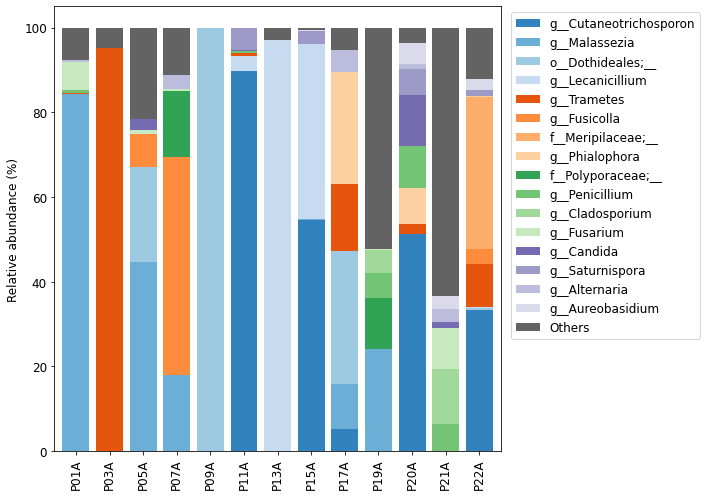

In [27]:
# use a different colour map
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend_short=False
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

# custom properties
ax1.tick_params(labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(12)


ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.savefig('./results/proteus_all_16taxa.png')

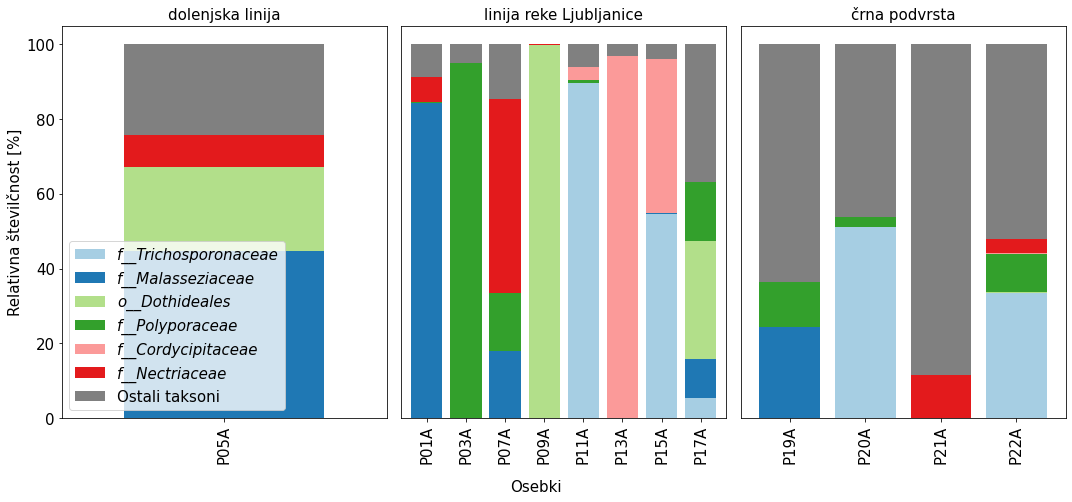

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

max_count = 7
groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=5, count=max_count, sort_by_mean2=False)

colors = list(plt.cm.Paired.colors)
colors[max_count-1] = 'gray'

for i, group in enumerate(groups):
    ax = axes[i]
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=ax,
        colors=colors,
        include_samples={'population': [group]},
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_title(group)

# custom properties    
fig.supxlabel('Osebki', fontsize = 15)
axes[0].set_ylabel('Relativna številčnost [%]')

        
h, l = axes[0].get_legend_handles_labels()
l[-1] = 'Ostali taksoni'

legend = axes[0].legend(h, l, prop={'size': 15, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')

for idx, ax in enumerate(axes):
    ax.tick_params(axis='x', labelrotation = 90, labelsize=15)  # reset rotation
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(15)
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations_fungi.png')

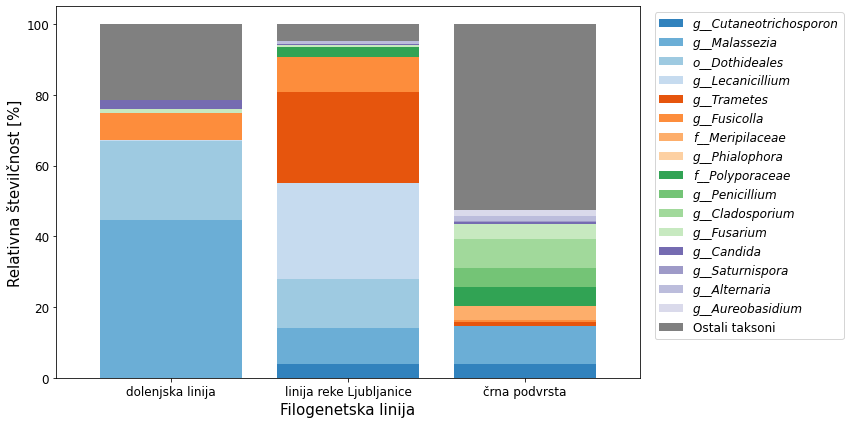

In [29]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [9, 1]})

max_count = 17
kwargs = dict(level=6, count=max_count, sort_by_mean2=False)

colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    group='population',
    group_order=['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend=False,
    colors=colors,
    **kwargs
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    group='population',
    group_order=['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend_short=True,
    colors=colors,
    **kwargs
)

# custom properties    
ax1.set_xlabel('Filogenetska linija', fontsize = 15)
ax1.set_ylabel('Relativna številčnost [%]')

handles, labels = ax2.get_legend_handles_labels()
labels[-1] = 'Ostali taksoni'

ax2.clear()
legend = ax2.legend(handles, labels, prop={'size': 12, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')
ax2.axis('off')

ax1.tick_params(labelrotation = 0, labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(15)


plt.tight_layout()
plt.savefig('./results/populations_together_fun.png')

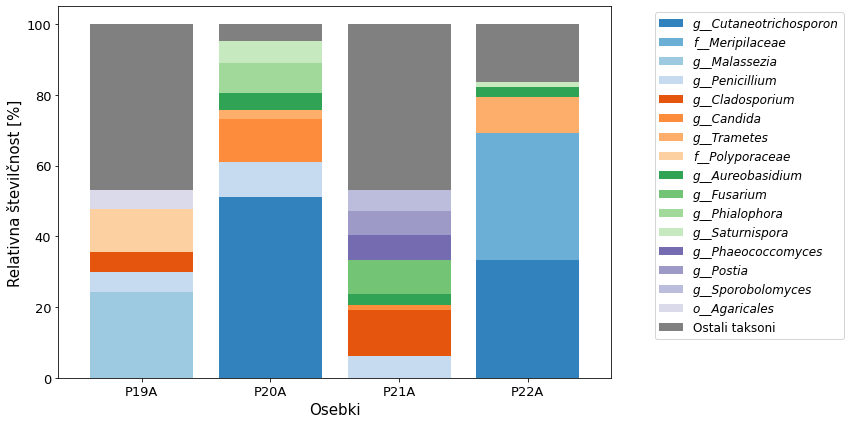

In [30]:
max_count = 17
colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

kwargs = dict(
    include_samples={'population': ['črna podvrsta']},
    label_columns=['sample-id'],
    level=6,
    count=max_count,
)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    colors=colors,
    legend=False,
    ax=ax1,
    **kwargs
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    colors=colors,
    legend_short=True,
    ax=ax2,
    **kwargs
)

# custom properties    
ax1.set_xlabel('Osebki', fontsize = 15)
ax1.set_ylabel('Relativna številčnost [%]')

handles, labels = ax2.get_legend_handles_labels()
labels[-1] = 'Ostali taksoni'

ax2.clear()
legend = ax2.legend(handles, labels, prop={'size': 12, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')
ax2.axis('off')

ax1.tick_params(labelrotation = 0, labelsize=13)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/crni_primerjava10najpogostejsih_fun.png')

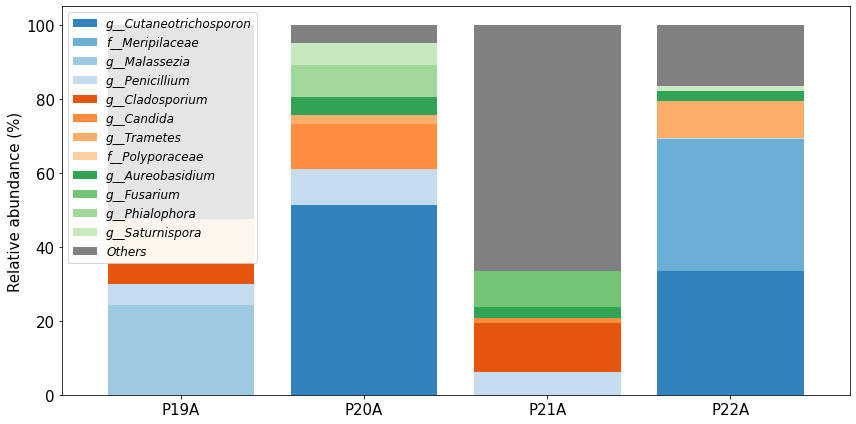

In [31]:
max_count = 13
colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

kwargs = dict(
    include_samples={'population': ['črna podvrsta']},
    label_columns=['sample-id'],
    level=6,
    count=max_count,
)

fig, ax = plt.subplots(figsize=(12, 6))

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    colors=colors,
    legend_short=True,
    ax=ax,
    **kwargs
)

handles, labels = ax.get_legend_handles_labels()

ax.tick_params(labelrotation = 0, labelsize=15) 
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
ax.legend(handles, labels, prop={'size': 12,'style': 'italic'})


plt.tight_layout()
plt.savefig('./results/crni_primerjava10najpogostejsih_fun_old.png')